In [1]:
!pip install scikit-image

In [2]:
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
import os
import pandas as pd
from datagen import* 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

Using TensorFlow backend.


In [3]:
# generating random patches
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [4]:
#for using roi

base = '/src/data/wd0/roi/rim_data/'
train_datagen = ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        #vertical_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        )

#train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        base + 'train',
        target_size=(320, 320),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        base + 'test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

#val_crops = crop_generator(validation_generator, 299)

#for using whole fundus
# separate val and train!
"""gl_df = pd.read_csv('/src/workspace/csv/glaucoma_fundus_files.csv', names = ['filepath'])
gl_list = gl_df['filepath'].tolist()
norm_df = pd.read_csv('/src/workspace/csv/no_disease_files.csv', names = ['filepath1', 'filepath2'])
norm_df1 = norm_df['filepath1'].tolist()
norm_df2 = norm_df['filepath2'].tolist()
norm_list = norm_df1 + norm_df2
norm_list_clean = []
i = 0
for ele in norm_list:
    if not pd.isnull(ele):
        i+=1
        if i%56 == 0:
            norm_list_clean.append(ele)
norm_train = []
norm_test = []
for i, ele in enumerate(norm_list_clean):
    if i%5 == 0:
        norm_test.append(ele)
    else:
        norm_train.append(ele)
gl_train = []
gl_test = []
for i, ele in enumerate(gl_list):
    if i%5 == 0:
        gl_test.append(ele)
    else:
        gl_train.append(ele)
train_generator = image_generator(files = norm_train+gl_train,
                          label_file = [[0,1] for x in range(len(norm_train))] + [[1,0] for x in range(len(gl_train))],
                          batch_size = 32, size = (320,320))

validation_generator = image_generator(files = norm_test+gl_test,
                          label_file = [[0,1]  for x in range(len(norm_test))] + [[1,0] for x in range(len(gl_test))],
                          batch_size = 32, size = (299,299))"""
train_crops = crop_generator(train_generator, 299)

Found 744 images belonging to 2 classes.
Found 187 images belonging to 2 classes.


In [18]:
# create the base pre-trained model
base_model = InceptionV3(weights = 'imagenet', include_top=False)

In [23]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.7)(x) 
# and a logistic layer --we have 2 classes
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = True
for layer in model.layers[249:]:
    layer.trainable = True

In [24]:
adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [25]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
callbacks_list = []
filepath= "weights/inceptionV3" + "-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list.append(checkpoint)
model_history = model.fit_generator(train_crops, 
        train_generator.samples/train_generator.batch_size,
        #106,
        validation_data = validation_generator, epochs = 25,
        validation_steps = validation_generator.samples/validation_generator.batch_size,
        #validation_steps = 26,                            
        callbacks = callbacks_list)

Epoch 1/25
24/23 [==============================] - 28s 1s/step - loss: 0.7553 - acc: 0.5844 - val_loss: 0.6093 - val_acc: 0.6257

Epoch 00001: val_acc improved from -inf to 0.62567, saving model to weights/inceptionV3-01-0.6257.hdf5
Epoch 2/25
24/23 [==============================] - 9s 367ms/step - loss: 0.7029 - acc: 0.6069 - val_loss: 0.5618 - val_acc: 0.6684

Epoch 00002: val_acc improved from 0.62567 to 0.66845, saving model to weights/inceptionV3-02-0.6684.hdf5
Epoch 3/25
24/23 [==============================] - 14s 586ms/step - loss: 0.6644 - acc: 0.6120 - val_loss: 0.4795 - val_acc: 0.7594

Epoch 00003: val_acc improved from 0.66845 to 0.75936, saving model to weights/inceptionV3-03-0.7594.hdf5
Epoch 4/25
24/23 [==============================] - 15s 611ms/step - loss: 0.5595 - acc: 0.7148 - val_loss: 0.4532 - val_acc: 0.7968

Epoch 00004: val_acc improved from 0.75936 to 0.79679, saving model to weights/inceptionV3-04-0.7968.hdf5
Epoch 5/25
24/23 [=============================

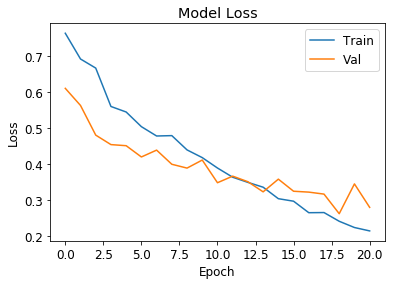

In [119]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(model_history.history['loss'][:21])
plt.plot(model_history.history['val_loss'][:21])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.savefig("diagrams/" + "rimLoss.svg")
plt.show()

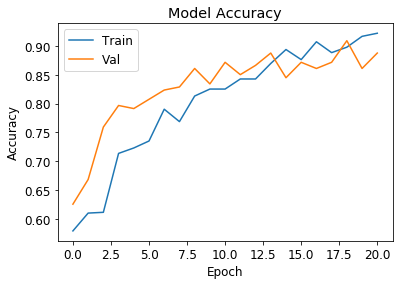

In [120]:
plt.figure()
plt.plot(model_history.history['acc'][:21])
plt.plot(model_history.history['val_acc'][:21])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.savefig("diagrams/" + "rimAcc.svg")
plt.show()

In [94]:
model.load_weights('weights/inceptionV3-19-0.9091.hdf5')

In [95]:
test_generator = test_datagen.flow_from_directory(
        base + 'test',
        target_size=(299, 299),
        shuffle = False,
        batch_size=1,
        class_mode='categorical')

filenames = test_generator.filenames
Y_test = test_generator.classes
nb_samples = len(filenames)

Found 187 images belonging to 2 classes.


In [96]:
preds = model.predict_generator(test_generator, validation_generator.samples)

In [97]:
Y_pred = np.argmax(preds, axis = 1)

In [98]:
ans = 0
for i in range(Y_test.shape[0]):
    if Y_test[i] == Y_pred[i]:
        #print Y_test[i], Y_pred[i]
        ans = ans + 1    

print("Test Accuracy is " + str((ans/float(Y_test.shape[0]))*100))

Test Accuracy is 88.23529411764706


In [99]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [100]:
state = {0:'Glaucoma', 1:'Normal'}
Y_state = np.array([state[a] for a in Y_test])
Y_pred_state = np.array([state[a] for a in Y_pred])

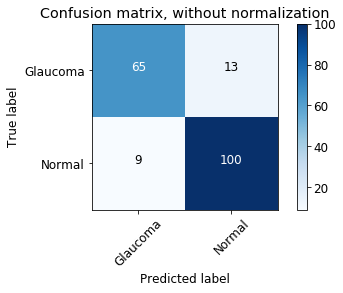

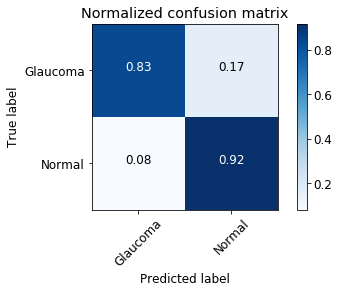

In [123]:
plt.rcParams.update({'font.size': 12})
class_names =[]
for k in range(2):
    class_names.append(state[k])
cnf_matrix = confusion_matrix(Y_state, Y_pred_state)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('diagrams/rimConf.svg')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('diagrams/rimNConf.svg')

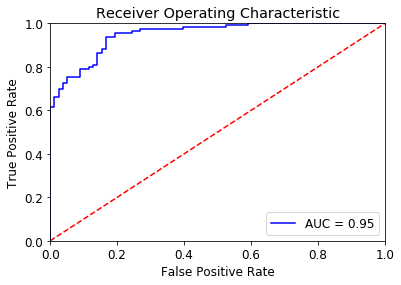

In [124]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
preds1 = preds[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("diagrams/" + "roc.svg")
plt.show()

In [ ]:
# try threshold of 0.6 as decision boundary for glaucoma

In [125]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [126]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [128]:
diag = SVG(model_to_dot(model).create(prog='dot', format='svg'))

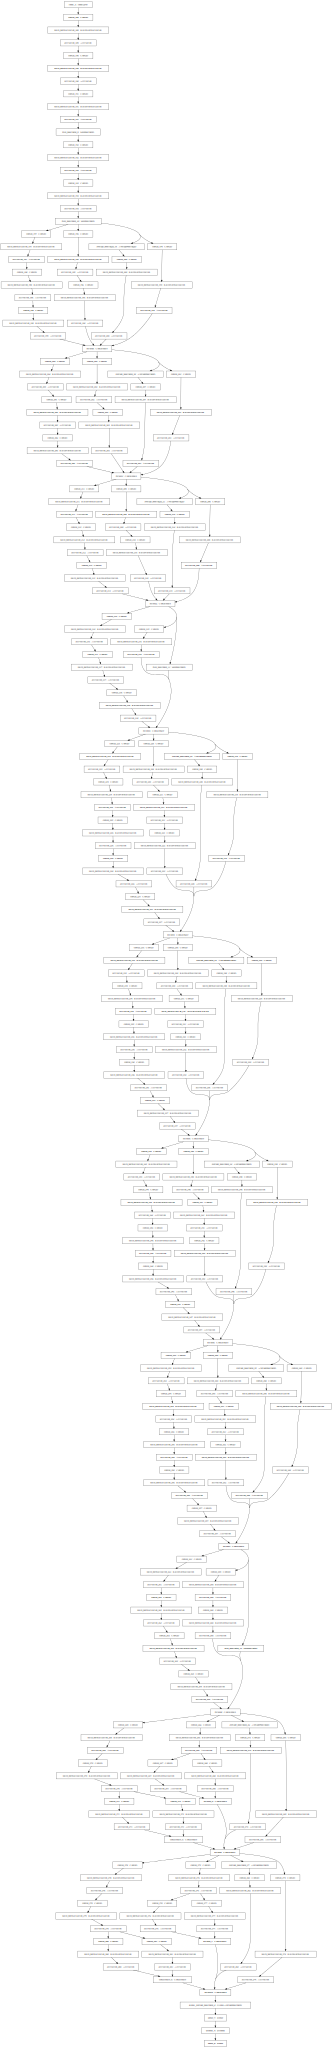

In [131]:
diag

In [134]:
diag.type

AttributeError: 'SVG' object has no attribute 'type'

In [135]:
from IPython.display import publish_display_data

In [138]:
publish_display_data({diag:'diag.svg'})

In [140]:
diag_dat = model_to_dot(model).create(prog='dot', format='svg')

In [141]:
file = open('diagrams/diag.svg', 'wb')

In [143]:
file.write(diag_dat)
file.close()

In [147]:
from keras.utils import plot_model
plot_model(model, to_file='diagrams/modelSimple.svg',show_layer_names = False, show_shapes = False)